## Chapter 3 : Labeling

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import itertools as it 

### [class pandas.Timedelta](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Timedelta.html)
Represents a duration, the difference between two dates or times.

Timedelta is the pandas equivalent of python’s datetime.timedelta and is interchangeable with it in most cases.

Parameters:	
value : Timedelta, timedelta, np.timedelta64, string, or integer
unit : string, {‘ns’, ‘us’, ‘ms’, ‘s’, ‘m’, ‘h’, ‘D’}, optional

Denote the unit of the input, if input is an integer. Default ‘ns’.

days, seconds, microseconds,
milliseconds, minutes, hours, weeks : numeric, optional

Values for construction in compat with datetime.timedelta. np ints and floats will be coereced to python ints and floats.

### SNIPPET 3.1 Daily Volaitility Estimates<a name='s_3_1'></a>
+ compute the daility volatility at intraday estimation points
+ apply a sapn of ```span0``` days to an EWMstd
+ see [pandas.Series.ewm](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html)

```python
def getDailityVol (close, span0 = 100):
    # daily vol, redindexed to close
    df0.close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0],df0.shape[0],:])
    df0 = close.loc[df0.index]/close.loc[df0.values].values-1 # dailiy returns
    df0 = df0.ewm(sapn = span0).std()
    return df0
```
    

In [55]:
def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()

In [56]:
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
getDailityVol(df,col_close='price')

#df['price'].index.searchsorted(df.index - pd.Timedelta(days=1))

### SNIPPET 3.2 TRIPLE-BARRIER LABELING METHOD
```python
def applyPtSlOnT1(close,events,ptSl,molecule):
# apply stop loss/profit taking, if it takes place before t1 (end of event)
events_=events.loc[molecule]
out=events_[['t1']].copy(deep=True)
if ptSl[0]>0:pt=ptSl[0]*events_['trgt']
else:pt=pd.Series(index=events.index) # NaNs
if ptSl[1]>0:sl=-ptSl[1]*events_['trgt']
else:sl=pd.Series(index=events.index) # NaNs
for loc,t1 in events_['t1'].fillna(close.index[-1]).iteritems():
df0=close[loc:t1] # path prices
df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss.
out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking.
return out
```

### SNIPPET 3.3 GETTING THE TIME OF FIRST TOUCH
```python
def getEvents(close,tEvents,ptSl,trgt,minRet,numThreads,t1=False):
#1) get target
trgt=trgt.loc[tEvents]
trgt=trgt[trgt>minRet] # minRet
#2) get t1 (max holding period)
if t1 is False:t1=pd.Series(pd.NaT,index=tEvents)
#3) form events object, apply stop loss on t1
side_=pd.Series(1.,index=trgt.index)
events=pd.concat({'t1':t1,'trgt':trgt,'side':side_}, \
axis=1).dropna(subset=['trgt'])
df0=mpPandasObj(func=applyPtSlOnT1,pdObj=('molecule',events.index), \
numThreads=numThreads,close=close,events=events,ptSl=[ptSl,ptSl])
events['t1']=df0.dropna(how='all').min(axis=1) # pd.min ignores nan
events=events.drop('side',axis=1)
return events
```

### SNIPPET 3.4 ADDING A VERTICAL BARRIER<a name='s_3_4'></a>

```python
t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
t1 = t1[t1< close.shape[0]]
t1= pd.Series(close.index[t1],index=tEvents[:t1.shape[0]])# NaNs at end
```

### SNIPPET 3.5 LABELING FOR SIDE AND SIZE
```python
def getBins(events,close):
#1) prices aligned with events
events_=events.dropna(subset=['t1'])
px=events_.index.union(events_['t1'].values).drop_duplicates()
px=close.reindex(px,method='bfill')
#2) create out object
out=pd.DataFrame(index=events_.index)
out['ret']=px.loc[events_['t1'].values].values/px.loc[events_.index]-1
out['bin']=np.sign(out['ret'])
return out
```

## Form Dollar bars for E-mini S&P 500 futures -> test.csv

## EXERCISES 3.1.a<a name='e_3_1_a'></a>
Apply a symmetric CUSUM filter, where the thrshold is the standard deviation of dailty returns - [snippet 3.1](#s_3_1)

In [38]:
df3_1 = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
df3_1.head()

'2018-11-21 09:02:00'

In [93]:
def npMovingAverage(data, window=3):
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()
    return df[col_dVol]

def CUSUM_dVol(
    df,
    col='close',
    window=20,
    h=0.05
   ):
    bar = df.drop(df.columns.difference([col]), axis=1)
    tmp = np.log(bar[col]).diff().fillna(0)
        
    ma = npMovingAverage(tmp,window)      
    tmp = tmp[window-1:]
    tmp = tmp - ma    
    
    dVol = getDailityVol(df,col_close='price')
    tmp_p = tmp - dVol
    tmp_n = tmp + dVol 
    
    tmp_p = list(it.accumulate(tmp_p, lambda x, y: max(x+y, 0) if (x+y) >= 0 else 0))
    tmp_n = list(it.accumulate(tmp_n, lambda x, y: min(x+y, 0) if (x+y) <= 0 else 0))
    
    s1 = [index for index, value in enumerate(tmp_p) if value !=0]
    s2 = [index for index, value in enumerate(tmp_n) if value !=0]
        
    s_p = bar.iloc[s1]
    s_n = bar.iloc[s2]    
    
    s_t = pd.concat([s_p,s_n],axis = 1,sort=True)
    s_t.columns = ['s_p','s_n']
    
    #s_t['s_t'] = s_t.apply(lambda x: x['s_n'] if pd.isna(x['s_p']) else x['s_p'],axis=1)
    
    return s_t

"df['ret'] = df['price'].pct_change()\ns_t_1['ret'] = s_t_1['s_t'].pct_change()\ns_t_2['ret'] =s_t_2['s_t'].pct_change()\n\ndisplay(df['ret'].autocorr(lag=1))\ndisplay(s_t_1['ret'].autocorr(lag=1))\ndisplay(s_t_2['ret'].autocorr(lag=1))"

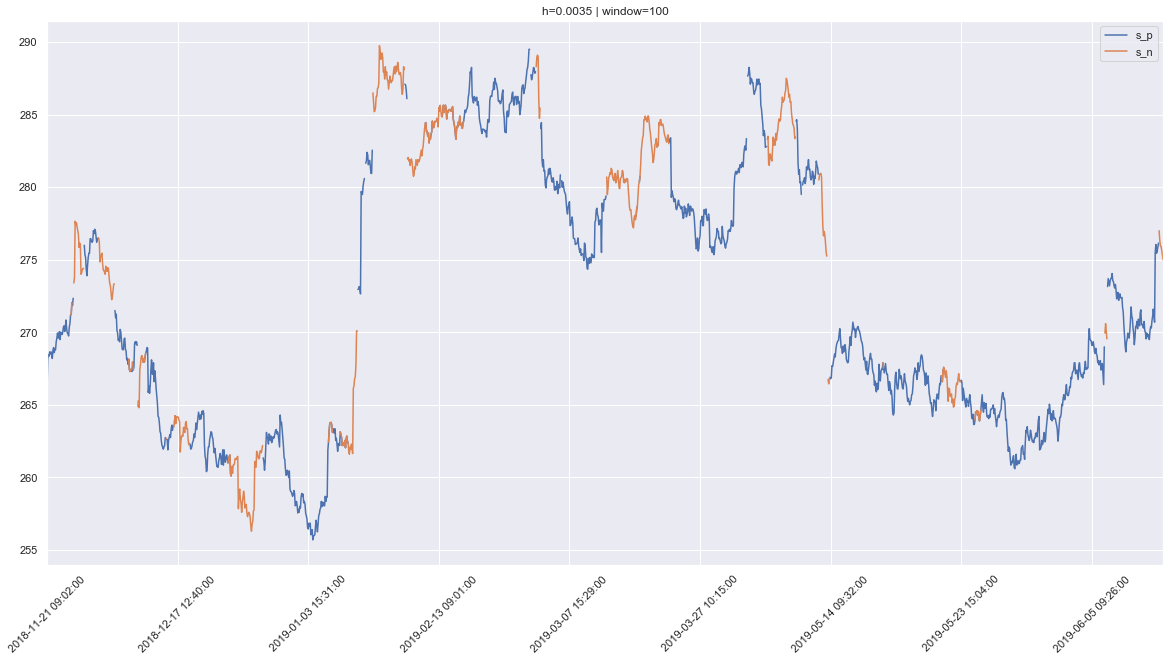

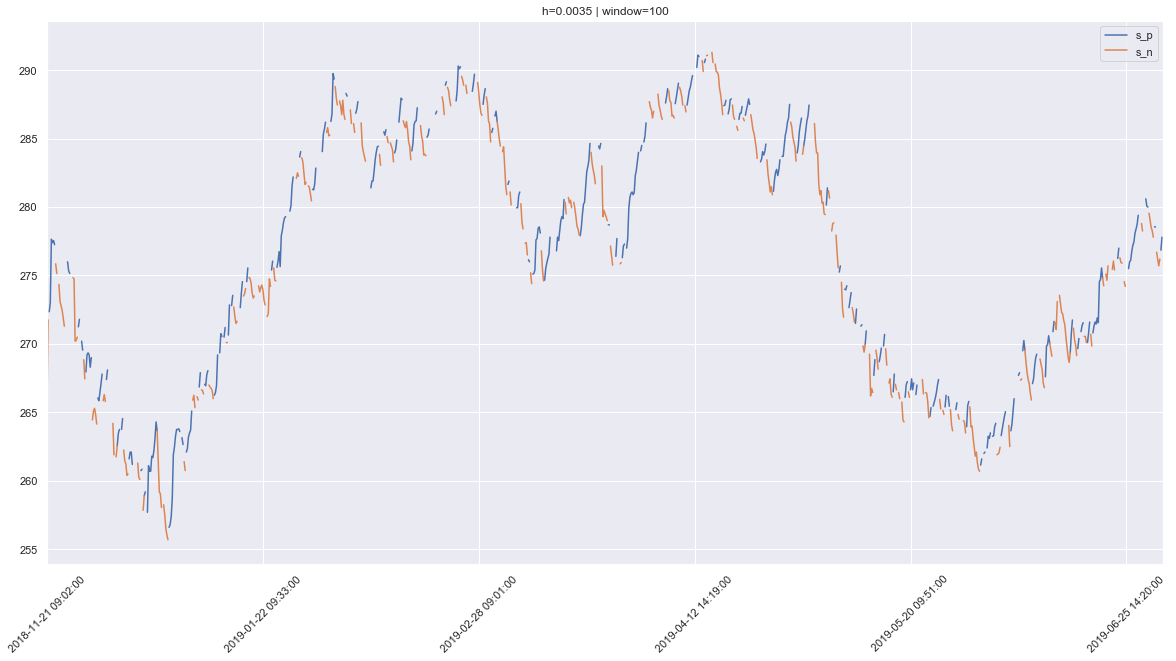

In [94]:
h_t = 0.0035

window=100
#s_t = CUSUM3('dollar_t5300000_d200.csv',h=h_t,window=window)
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
s_t_1= CUSUM_4(df,h=h_t,window=window,col='price')
s_t_2 = CUSUM_dVol(df,h=h_t,window=window,col='price')


#getDailityVol(df,col_close='price')
s_t_1.plot(
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=(20,10),
    title='h=' + str(h_t) + ' | window='+str(window)
)
s_t_2.plot(
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=(20,10),
    title='h=' + str(h_t) + ' | window='+str(window)
)

'''df['ret'] = df['price'].pct_change()
s_t_1['ret'] = s_t_1['s_t'].pct_change()
s_t_2['ret'] =s_t_2['s_t'].pct_change()

display(df['ret'].autocorr(lag=1))
display(s_t_1['ret'].autocorr(lag=1))
display(s_t_2['ret'].autocorr(lag=1))'''

특정한 값을 기준으로 필터를 할 경우 p 나 n이 한쪽으로 몰려서 같이 나타나는 것이 많은데, Daily Volitile 로 할 경우 p와 n 이 확연히 구분되서 나타난다. 

## EXERCISES 3.1.b<a name='e_3_1_b'></a>
Use Snippet 3.4 on a pandas series ```t1```, where ```numDays = 1```

## EXERCISES 3.1.c<a name='e_3_1_c'></a>
On those samped features, applay the triple-barrier method, where ```psS1=[1,1]``` and ```t1``` is the series you crated in point 1.b

=> 하루 이상 0 이 유지되면 t1으로 하자

현재 
1. 각각의 경우에 label 을 아직 안해줌
2. +,- 둘 다 체크해서 중복 발생

In [84]:
def npMovingAverage(data, window=3):
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()
    return df[col_dVol]

def CUSUM_Triple(
    df,
    col='close',
    window=20,
    h=0.05
   ):
    bar = df.drop(df.columns.difference([col]), axis=1)
    tmp = np.log(bar[col]).diff().fillna(0)
        
    ma = npMovingAverage(tmp,window)      
    tmp = tmp[window-1:]
    tmp = tmp - ma    
    
    dVol = getDailityVol(df,col_close='price')
    tmp_p = tmp - dVol
    tmp_n = tmp + dVol
    tmp_p = list(it.accumulate(tmp_p, lambda x, y: max(x+y, 0) if (x+y) >= 0 else 0))
    tmp_n = list(it.accumulate(tmp_n, lambda x, y: min(x+y, 0) if (x+y) <= 0 else 0))
    
    
    def verticalCheck(index,value):
        nonlocal prev_idx 
        nonlocal bar
        if(value==0):
            return False
        # TODO 다듬어야함.
        t = pd.Timedelta(pd.to_datetime(bar.index[index]) - pd.to_datetime(prev_idx)).days
        #print(t)
        if(t < 1):
            return False        
        prev_idx = bar.index[index]
        return True
    prev_idx = tmp.index[0]
    s1 = [index for index, value in enumerate(tmp_p) if verticalCheck(index,value)]
    prev_idx = tmp.index[0]
    s2 = [index for index, value in enumerate(tmp_n) if verticalCheck(index,value)]
    
    s_p = bar.iloc[s1]
    s_n = bar.iloc[s2]    
    
    s_t = pd.concat([s_p,s_n],axis = 1,sort=True)
    s_t.columns = ['s_p','s_n']
    
    s_t['s_t'] = s_t.apply(lambda x: x['s_n'] if pd.isna(x['s_p']) else x['s_p'],axis=1)
    
    return s_t

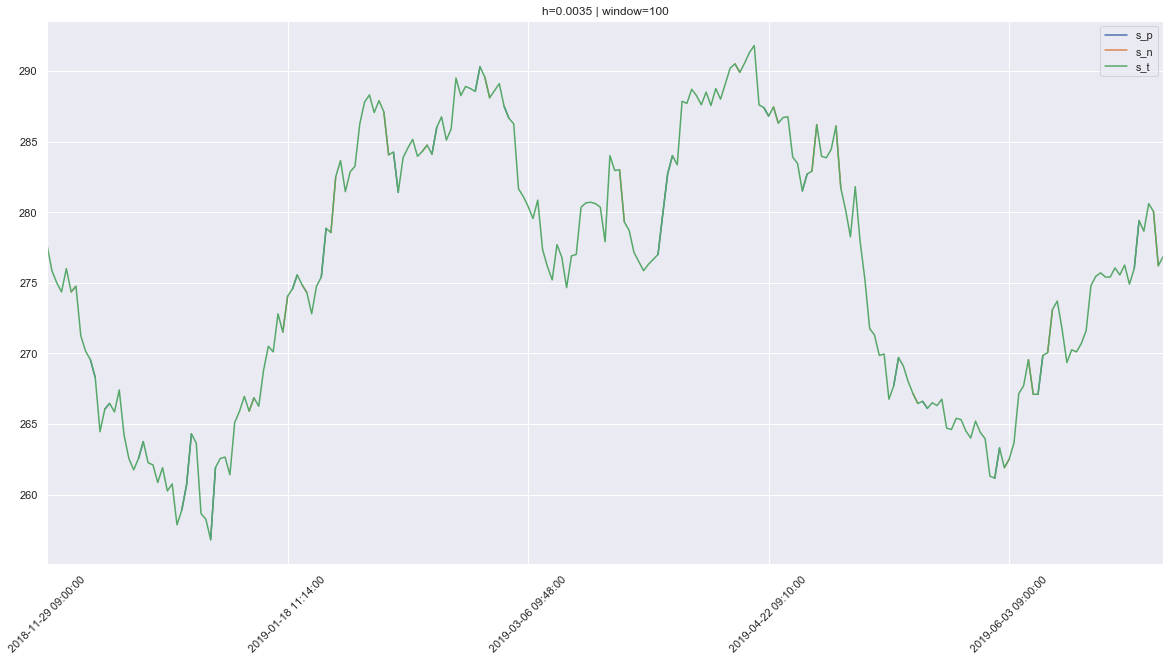

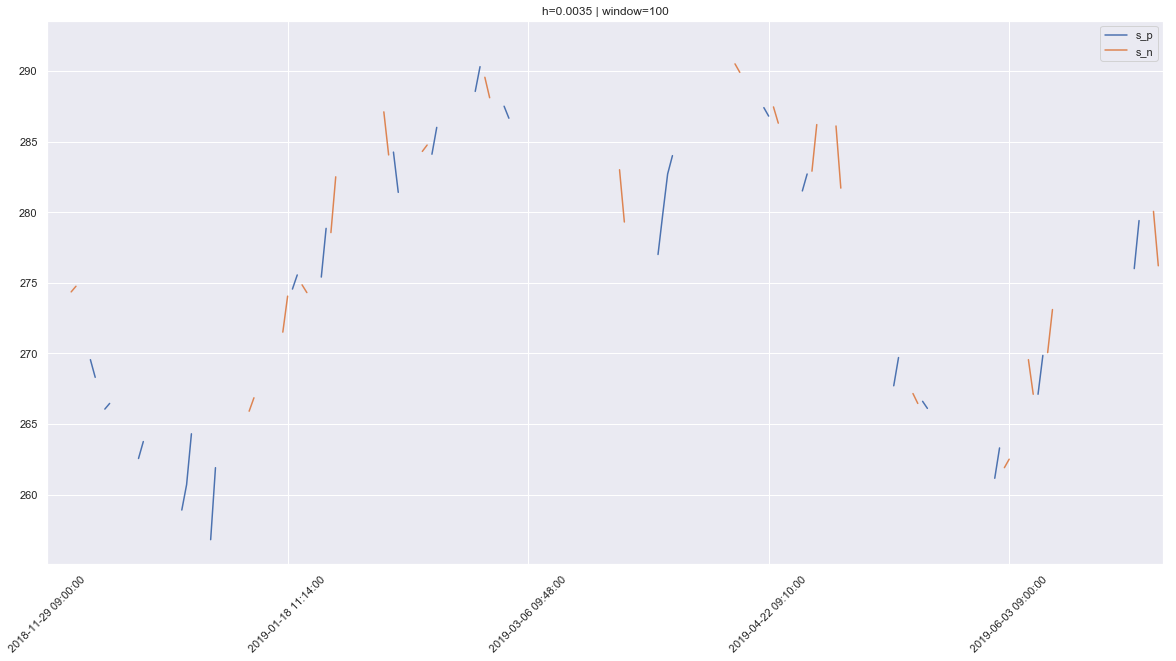

In [88]:
window=100
#s_t = CUSUM3('dollar_t5300000_d200.csv',h=h_t,window=window)
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
s_t_1= CUSUM_Triple(df,h=h_t,window=window,col='price')

s_t_1.plot(    
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=(20,10),
    title='h=' + str(h_t) + ' | window='+str(window)
)
s_t_1 = s_t_1.drop(columns=['s_t'])
s_t_1.plot(    
    use_index =True,
    subplots=False,
    sharex =True,
    rot =45,
    figsize=(20,10),
    title='h=' + str(h_t) + ' | window='+str(window)
)

## EXERCISES 3.1.d<a name='e_3_1_d'></a>
Apply ```getBins``` to generate lables

In [122]:
def npMovingAverage(data, window=3):
    weights = np.ones(window) / window
    return np.convolve(data, weights, mode='valid')

def getDailityVol (
    df,
    col_close='close',
    col_dVol='dVol',
    span0 = 100
    ):
    df[col_dVol]=df[col_close].pct_change()
    df[col_dVol] = df[col_dVol].ewm(span=100).std()
    return df[col_dVol]

def CUSUM_Triple(
    df,
    col='close',
    window=20,
    h=0.05
   ):
    bar = df.drop(df.columns.difference([col]), axis=1)
    tmp = np.log(bar[col]).diff().fillna(0)
        
    ma = npMovingAverage(tmp,window)      
    tmp = tmp[window-1:]
    tmp = tmp - ma    
    
    dVol = getDailityVol(df,col_close='price')
    tmp_p = tmp - dVol
    tmp_n = tmp + dVol
    tmp_p = list(it.accumulate(tmp_p, lambda x, y: max(x+y, 0) if (x+y) >= 0 else 0))
    tmp_n = list(it.accumulate(tmp_n, lambda x, y: min(x+y, 0) if (x+y) <= 0 else 0))
    
    
    def verticalCheck(index,value):
        nonlocal prev_idx 
        nonlocal bar
        if(value[0]!=0 or value[1]!=0):
            return False
        # TODO 다듬어야함.
        t = pd.Timedelta(pd.to_datetime(bar.index[index]) - pd.to_datetime(prev_idx)).days
        #print(str(pd.to_datetime(bar.index[index])) + ' - ' + str(pd.to_datetime(prev_idx)) +' = '+  str(t))
        
        if(t < 1):
            return False        
        prev_idx = bar.index[index]
        return True
    prev_idx = tmp.index[0]
    print(tmp_n.index) 
    s1 = [index for index, value in enumerate(tmp_p) if value !=0]
    s2 = [index for index, value in enumerate(tmp_n) if value !=0]
    s3 = [index for index, value in enumerate( zip(tmp_p,tmp_n)) if verticalCheck(index,value)]
    
    s_p = bar.iloc[s1]
    s_n = bar.iloc[s2]
    s_t = bar.iloc[s3]
    
    triple = pd.concat([s_p,s_t,s_n],axis = 1,sort=True)
    triple.columns = ['s_p','s_t','s_n']
    
   # s_t['bin'] = s_t.apply(lambda x: -1 if pd.isna(x['s_p']) else 1 ,axis=1)
    
    return triple

In [123]:
window=100
#s_t = CUSUM3('dollar_t5300000_d200.csv',h=h_t,window=window)
df = pd.read_csv('dollar_D_15.csv',index_col='timestamp')
triple= CUSUM_Triple(df,h=h_t,window=window,col='price')

triple

<built-in method index of list object at 0x0000022D720FDDC8>


,s_p,s_t,s_n
2018-11-21 09:02:00,266.149994,NaN,266.149994
2018-11-28 11:01:00,NaN,NaN,271.750000
2018-11-28 11:33:00,272.350006,NaN,NaN
2018-11-28 11:55:00,273.000000,NaN,NaN
2018-11-29 09:00:00,277.649994,NaN,NaN
2018-11-29 09:03:00,277.399994,NaN,NaN
2018-11-29 09:09:00,277.549988,NaN,NaN
2018-11-29 09:15:00,277.250000,NaN,NaN
2018-11-29 09:28:00,NaN,277.000000,NaN
2018-11-29 09:54:00,NaN,NaN,275.850006
